<a href="https://colab.research.google.com/github/antoniogonzalezai/Detection-of-myocardial-infarction-AI/blob/main/ECG200.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

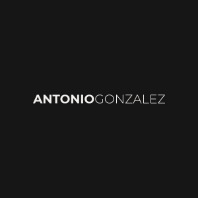


##**ECG200**

*This dataset was formatted by R. Olszewski as part of his thesis "Generalized feature extraction for structural pattern recognition in time-series data" at Carnegie Mellon University, 2001. Each series traces the electrical activity recorded during one heartbeat. The two classes are a normal heartbeat and a Myocardial Infarction.*


http://www.timeseriesclassification.com/description.php?Dataset=ECG200


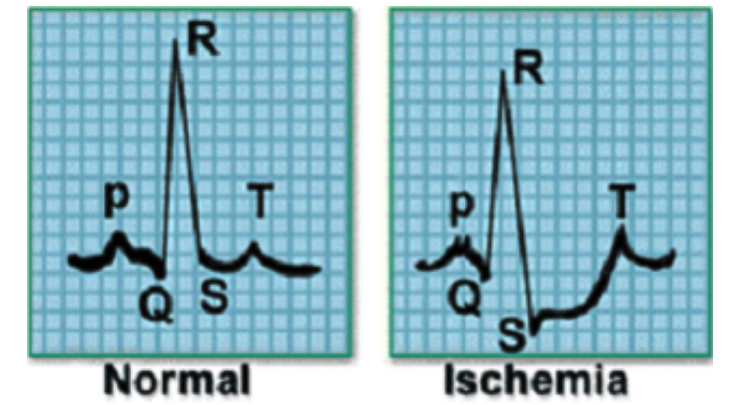

## **Download Dataset from google storage**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
!curl https://sdk.cloud.google.com | bash

In [ ]:
!gsutil cp gs://neurasys-datasets/ECG200/ECG200.xlsx .

## **Load Dataset**

In [ ]:
dataframe = pd.read_excel('/content/ECG200.xlsx',header=None)
raw_data = dataframe.values
dataframe.head(10)

##**The two classes are a normal heartbeat and a Myocardial Infarction**

##*Normal heartbeat = 1*

##*Myocardial Infarction = 0*

In [ ]:
labels = raw_data[:, -1]

data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

## **Normalize the data to [0,1]**

In [ ]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

 ## **Separate normal rhythms from abnormal ones.**

In [ ]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

## **View a normal heartbeat.**

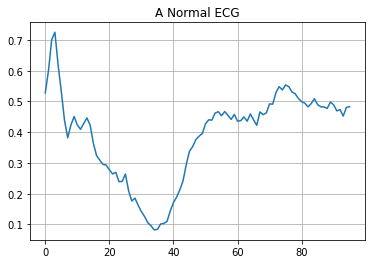

In [ ]:
plt.grid()
plt.plot(np.arange(96), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

##**View a Myocardial Infarction.**



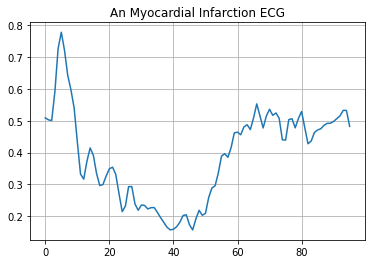

In [ ]:
plt.grid()
plt.plot(np.arange(96), anomalous_train_data[0])
plt.title("An Myocardial Infarction ECG")
plt.show()

##**Build an automatic encoder**

In [ ]:
np.random.seed(23)

class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(96, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [ ]:
autoencoder.compile(optimizer='adam', loss='mae')

##**Train the model**

In [ ]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=200, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

##**Reconstruction of a normal heartbeat**

In [ ]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(96), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Normal", "Reconstruction", "Error"])
plt.show()

##**Reconstruction of a myocardial infarction**

In [ ]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(96), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Myocardial", "Reconstruction", "Error"])
plt.show()

##**Plot the reconstruction error on normal ECG from the training set**

In [ ]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

##**threshold that is one standard deviation above the mean**

In [ ]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

##**Plot the threshold**

In [ ]:
plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.vlines(threshold,0,8,'k')
plt.show()

##**Get model accuracy**

In [ ]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)